<a href="https://colab.research.google.com/github/rchicangana/AnalisisDatosProyecto/blob/main/ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1  Introduccion

El análisis exploratorio de datos es una etapa fundamental en cualquier proyecto de Inteligencia Artificial y Ciencia de Datos, puesto que permite entender las características y patrones en los datos, así como identificar relaciones entre variables.

A continuación se presenta un estudio basado en datos de consumo de energía eléctrica horaria registrados en Cali, Colombia, junto con las temperaturas correspondientes a cada hora. El objetivo principal es explorar la relación entre estas dos variables y, posteriormente, aplicar diferentes modelos para realizar el pronósticos de corto plazo del demanda de energía.

In [186]:
import glob

# Cargar datasets de humedad
humedad_files = glob.glob("Data/reporte_sisaire-humedad-*.csv")
df_humedad_list = [pd.read_csv(file) for file in humedad_files]
df_humedad = pd.concat(df_humedad_list)

# Convertir fechas en el dataset de humedad
df_humedad["Fecha inicial"] = pd.to_datetime(df_humedad["Fecha inicial"], format="%Y-%m-%d %H:%M")

# Promediar la humedad por hora
df_humedad_avg = df_humedad.groupby("Fecha inicial")["HAire2"].mean().reset_index()
df_humedad_avg.rename(columns={"Fecha inicial": "FECHA", "HAire2": "HUMEDAD"}, inplace=True)

df_humedad_avg.head()

,FECHA,HUMEDAD
0,2017-01-01 00:00:00,82.75
1,2017-01-01 01:00:00,83.05
2,2017-01-01 02:00:00,83.50
3,2017-01-01 03:00:00,84.95
4,2017-01-01 04:00:00,85.30


In [187]:
# Cargar datasets de velocidad del viento
viento_files = glob.glob("Data/reporte_sisaire-vViento-*.csv")
df_viento_list = [pd.read_csv(file) for file in viento_files]
df_viento = pd.concat(df_viento_list)

# Convertir fechas en el dataset de viento
df_viento["Fecha inicial"] = pd.to_datetime(df_viento["Fecha inicial"], format="%Y-%m-%d %H:%M")

# Promediar la velocidad del viento por hora
df_viento_avg = df_viento.groupby("Fecha inicial")["VViento"].mean().reset_index()
df_viento_avg.rename(columns={"Fecha inicial": "FECHA", "VViento": "VIENTO"}, inplace=True)

df_viento_avg.head()

,FECHA,VIENTO
0,2017-01-01 00:00:00,0.75
1,2017-01-01 01:00:00,0.70
2,2017-01-01 02:00:00,0.75
3,2017-01-01 03:00:00,0.80
4,2017-01-01 04:00:00,0.95


# 2  Contexto

La demanda de energía eléctrica en una ciudad se ve inlfuenciada por muchos factores, como la temperatura, factores sociales, cronograma de produccion de grandes clientes, entre otros.

En regiones con climas variables, como es el caso de muchas ciudades Colombianas, la demanda es afectada por el uso intensivo de sistemas de refrigeración en épocas calurosas.

Los datos utilizados en este análisis incluyen mediciones horarias del consumo de energía y la temperatura registrada en la misma franja horaria, tipos de dia, mes y año. Lo que permite explorar la correlación entre estas variables.

Adicionalmente, se busca evaluar el desempeño de diferentes modelos como regresiones lineales, redes neuronales y modelos basados en árboles de decisión, para predecir el consumo de energía en un horizonte de corto plazo.

## 2.1  Descripción de los campos

- FECHA: Fecha en formato ISO de la lectura del consumo
- TEMPERATURA: Temperatura en grados Centigrados al momento de la toma del dato
- CONSUMO: Variable objetvio medido en MVA

In [188]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

import holidays


#importo el dataset Principal
df = pd.read_csv('Data/datasetEmcali.csv')



In [189]:
#Defino el formato de la fecha
df["FECHA"] = pd.to_datetime(df["FECHA"], format="mixed", errors="coerce")

# Unir los datos de humedad y viento con el dataset principal
df_humedad_avg["FECHA"] = pd.to_datetime(df_humedad_avg["FECHA"])
df_viento_avg["FECHA"] = pd.to_datetime(df_viento_avg["FECHA"])

df = df.merge(df_humedad_avg, on="FECHA", how="left", suffixes=("","_extra"))
df = df.merge(df_viento_avg, on="FECHA", how="left" , suffixes=("","_extra"))

# Combinar las columnas duplicadas en una sola, tomando el promedio de los valores
#df["HUMEDAD"] = df[["HUMEDAD", "HUMEDAD_extra"]].mean(axis=1)
#df["VIENTO"] = df[["VIENTO", "VIENTO_extra"]].mean(axis=1)

# Eliminar las columnas duplicadas
#df = df.drop(columns=[col for col in df.columns if col.endswith("_extra")])
df = df.drop(columns=[col for col in df.columns if col.endswith("_x")])
df = df.drop(columns=[col for col in df.columns if col.endswith("_y")])

print("primeras filas \n")
print(df.head())


print("se describen las columnas \n")
print(df.info())

print("dimensiones \n")
print(df.shape)

primeras filas 

                FECHA  TEMPERATURA  CONSUMO  HUMEDAD  VIENTO
0 2017-12-01 00:00:00         27.9    409.0    72.55     2.6
1 2017-12-01 01:00:00         29.0    387.0    73.40     3.1
2 2017-12-01 02:00:00         29.1    378.0    75.65     2.4
3 2017-12-01 03:00:00         28.2    370.0    78.35     2.3
4 2017-12-01 04:00:00         26.7    364.0    80.00     1.0
se describen las columnas 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29808 entries, 0 to 29807
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   FECHA        29808 non-null  datetime64[ns]
 1   TEMPERATURA  29616 non-null  float64       
 2   CONSUMO      29520 non-null  float64       
 3   HUMEDAD      27029 non-null  float64       
 4   VIENTO       29123 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.1 MB
None
dimensiones 

(29808, 5)


# 3  Análisis exploratorio


## 3.1  Análisis de estructura


Se realiza un analisis de la forma del dataset, se relacionan tipos de datos, estadisticas descriptivas y valores nulos.

Se adicionan columnas, basadas en la fecha, con la hipotesis que esto permitira al modelo entender e interpretar mejor los datos.

In [190]:

# le doy formato a las columnas que va a ser numericas
df['CONSUMO'] = pd.to_numeric(df['CONSUMO'], errors='coerce')

df['TEMPERATURA'] = pd.to_numeric(df['TEMPERATURA'], errors='coerce')

df['HUMEDAD'] = pd.to_numeric(df['HUMEDAD'], errors='coerce')

df['VIENTO'] = pd.to_numeric(df['VIENTO'], errors='coerce')

# Elimino las filas que tienen valores nulos en 'FECHA' y 'CONSUMO', 'TEMPERATURA', 'HUMEDAD', 'VIENTO'

df = df.dropna(subset=['FECHA', 'CONSUMO', 'TEMPERATURA', 'HUMEDAD', 'VIENTO'])
    


def es_festivo_colombia(fecha):
    """Verifica si una fecha es festivo en Colombia."""
    co_holidays = holidays.CO(years=fecha.year)
    return fecha in co_holidays
df['Is_holiday'] = df['FECHA'].apply(es_festivo_colombia)

# Extract numerical features from 'FECHA'
df['Year'] = df['FECHA'].dt.year
df['Month'] = df['FECHA'].dt.month
df['Day'] = df['FECHA'].dt.day
df['Hour'] = df['FECHA'].dt.hour
df['Dayofweek'] = df['FECHA'].dt.dayofweek
df['Dayofyear'] = df['FECHA'].dt.dayofyear
df['Weekofyear'] = df['FECHA'].dt.isocalendar().week
df['Is_month_end'] = df['FECHA'].dt.is_month_end
df['Is_month_start'] = df['FECHA'].dt.is_month_start
df['Is_quarter_end'] = df['FECHA'].dt.is_quarter_end
df['Is_quarter_start'] = df['FECHA'].dt.is_quarter_start
df['Is_year_end'] = df['FECHA'].dt.is_year_end
df['Is_year_start'] = df['FECHA'].dt.is_year_start

# Eliminar la columna 'FECHA'
df = df.drop('FECHA', axis=1)

# Convert categorical columns to categorical
categorical_cols = ['Year', 'Month', 'Day', 'Hour', 'Dayofweek', 'Dayofyear', 'Weekofyear']
for col in categorical_cols:
    df[col] = df[col].astype('category')

print("Forma de lo datos:", df.shape)
print("\nTipo de datos por columnas:\n\n", df.dtypes)
print("\nEstadisticas descriptivas:\n\n", df.describe())
print("\nValores Faltantes:\n\n", df.isnull().sum())
print("\nValores Faltantes(%):\n\n", (df.isnull().sum() / len(df)) * 100)

Forma de lo datos: (26168, 18)

Tipo de datos por columnas:

 TEMPERATURA          float64
CONSUMO              float64
HUMEDAD              float64
VIENTO               float64
Is_holiday              bool
Year                category
Month               category
Day                 category
Hour                category
Dayofweek           category
Dayofyear           category
Weekofyear          category
Is_month_end            bool
Is_month_start          bool
Is_quarter_end          bool
Is_quarter_start        bool
Is_year_end             bool
Is_year_start           bool
dtype: object

Estadisticas descriptivas:

         TEMPERATURA       CONSUMO       HUMEDAD        VIENTO
count  26168.000000  26168.000000  26168.000000  26168.000000
mean      24.166783    455.835792     67.572628      2.056769
std        3.205015     96.408024     13.826779      1.381898
min       16.100000    227.000000     14.850000      0.100000
25%       21.700000    371.000000     56.010714      1.200000


se notan valores nulos

## 3.2  Análisis de variables numericas y continuas


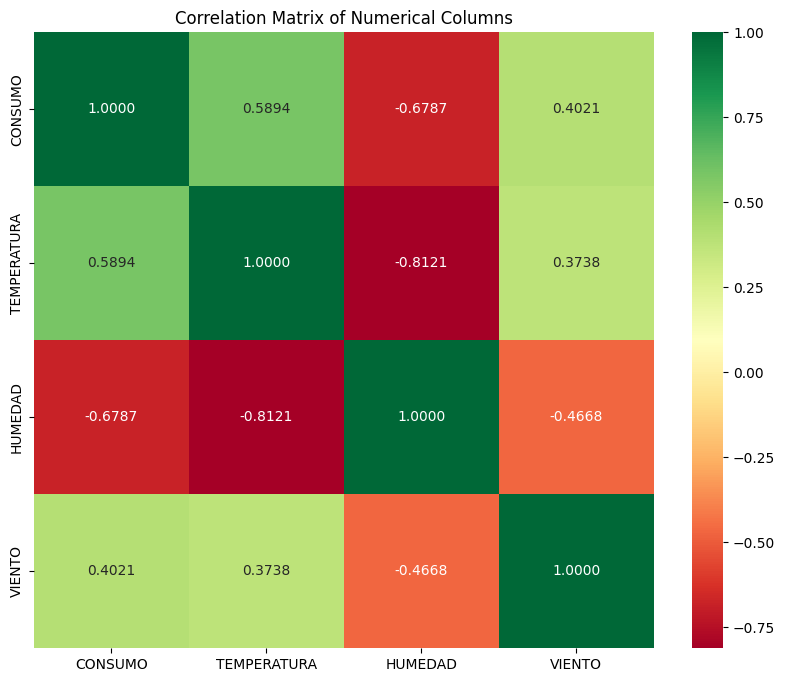

Correlation between TEMPERATURA and CONSUMO: 0.5894322061383508
Correlation between CONSUMO and CONSUMO: 1.0
Correlation between HUMEDAD and CONSUMO: -0.6786657608505726
Correlation between VIENTO and CONSUMO: 0.40207888466059827


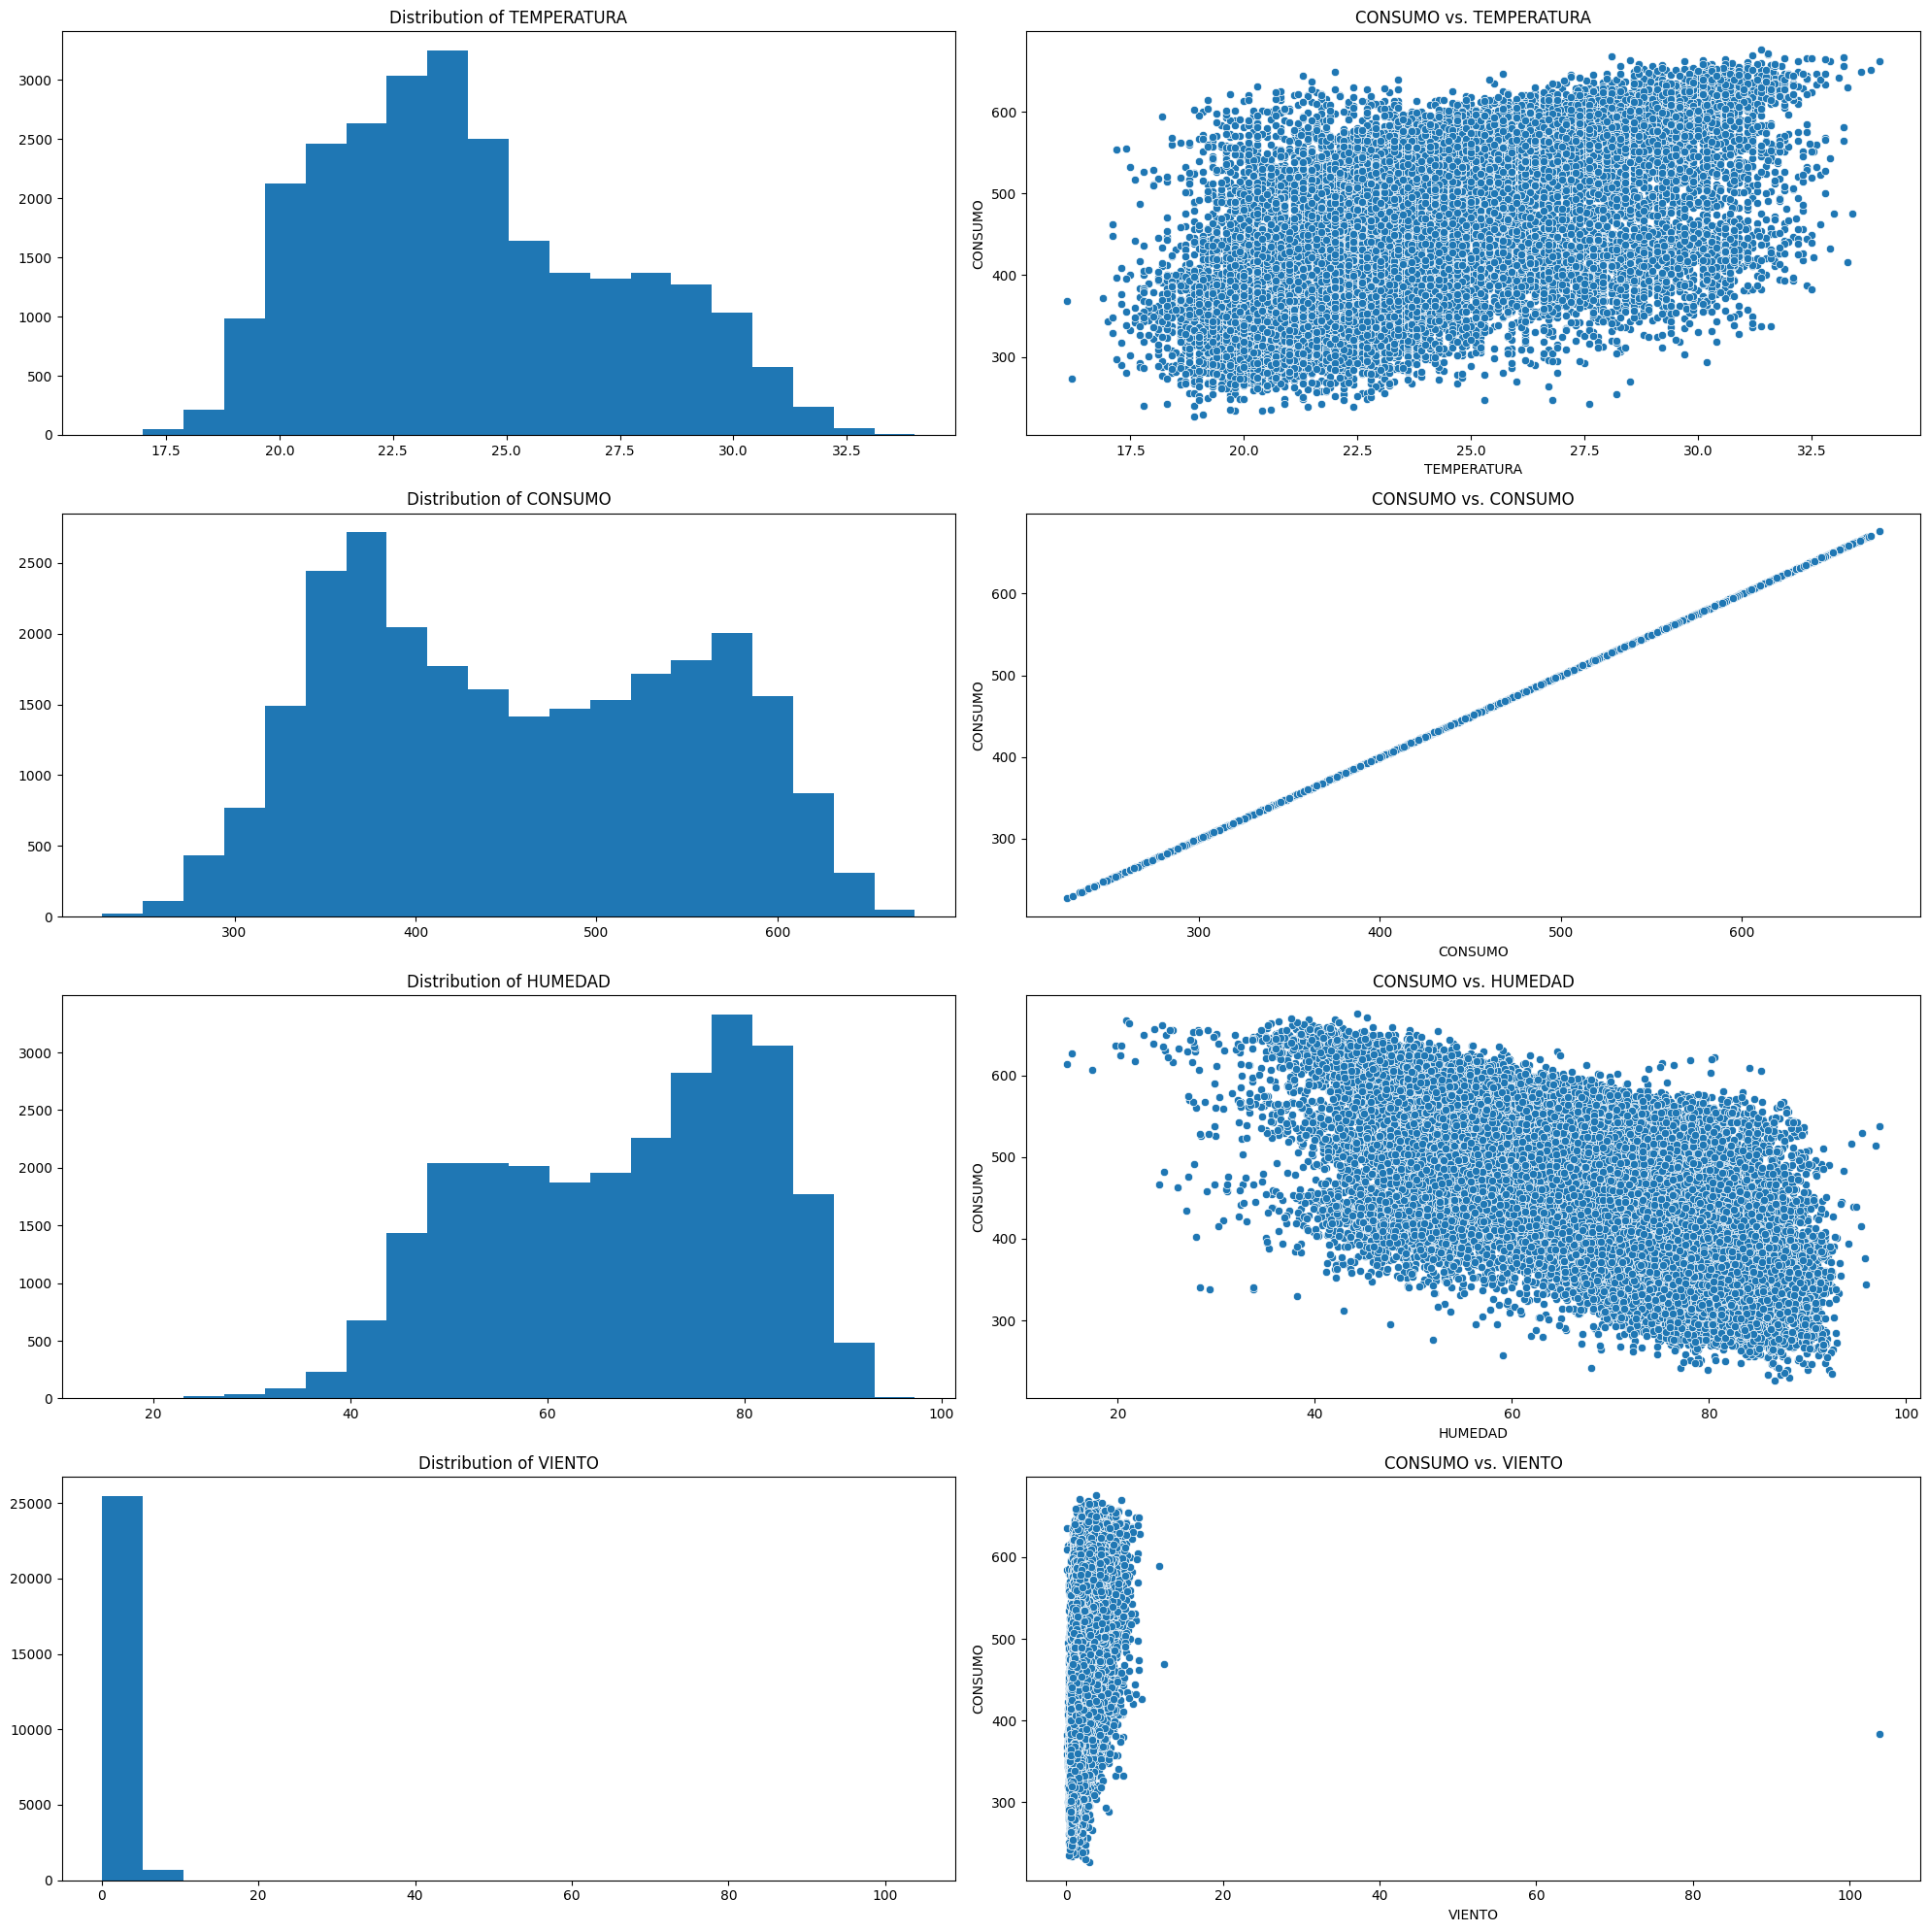

In [191]:

numerical_columns = ['CONSUMO', 'TEMPERATURA', 'HUMEDAD', 'VIENTO']

correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(10, 8))

#Matriz de correlación del DataFrame con valores de correlación entre -1 y 1, utilizando una paleta de colores verde-amarillo-rojo para resaltar las relaciones positivas y negativas, respectivamente.
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', fmt="0.4f")

plt.title('Correlation Matrix of Numerical Columns')

plt.show()

continuous_cols = ['TEMPERATURA', 'CONSUMO', 'HUMEDAD', 'VIENTO']

num_cols = 2  # columns per row
num_rows = (len(continuous_cols) * 2 + num_cols - 1) // num_cols # Calculate the rows needed.

# Create subplots in a grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(continuous_cols):
    # Histogram
    axes[i * 2].hist(df[col], bins=20)
    axes[i * 2].set_title(f'Distribution of {col}')

    # Scatterplot
    sns.scatterplot(x=col, y='CONSUMO', data=df, ax=axes[i * 2 + 1])
    axes[i * 2 + 1].set_title(f'CONSUMO vs. {col}')

    correlation = df[col].corr(df['CONSUMO'])
    print(f"Correlation between {col} and CONSUMO: {correlation}")

# Remove any unused subplots
for j in range(len(continuous_cols) * 2, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 3.3  Análisis de variables Categoricas


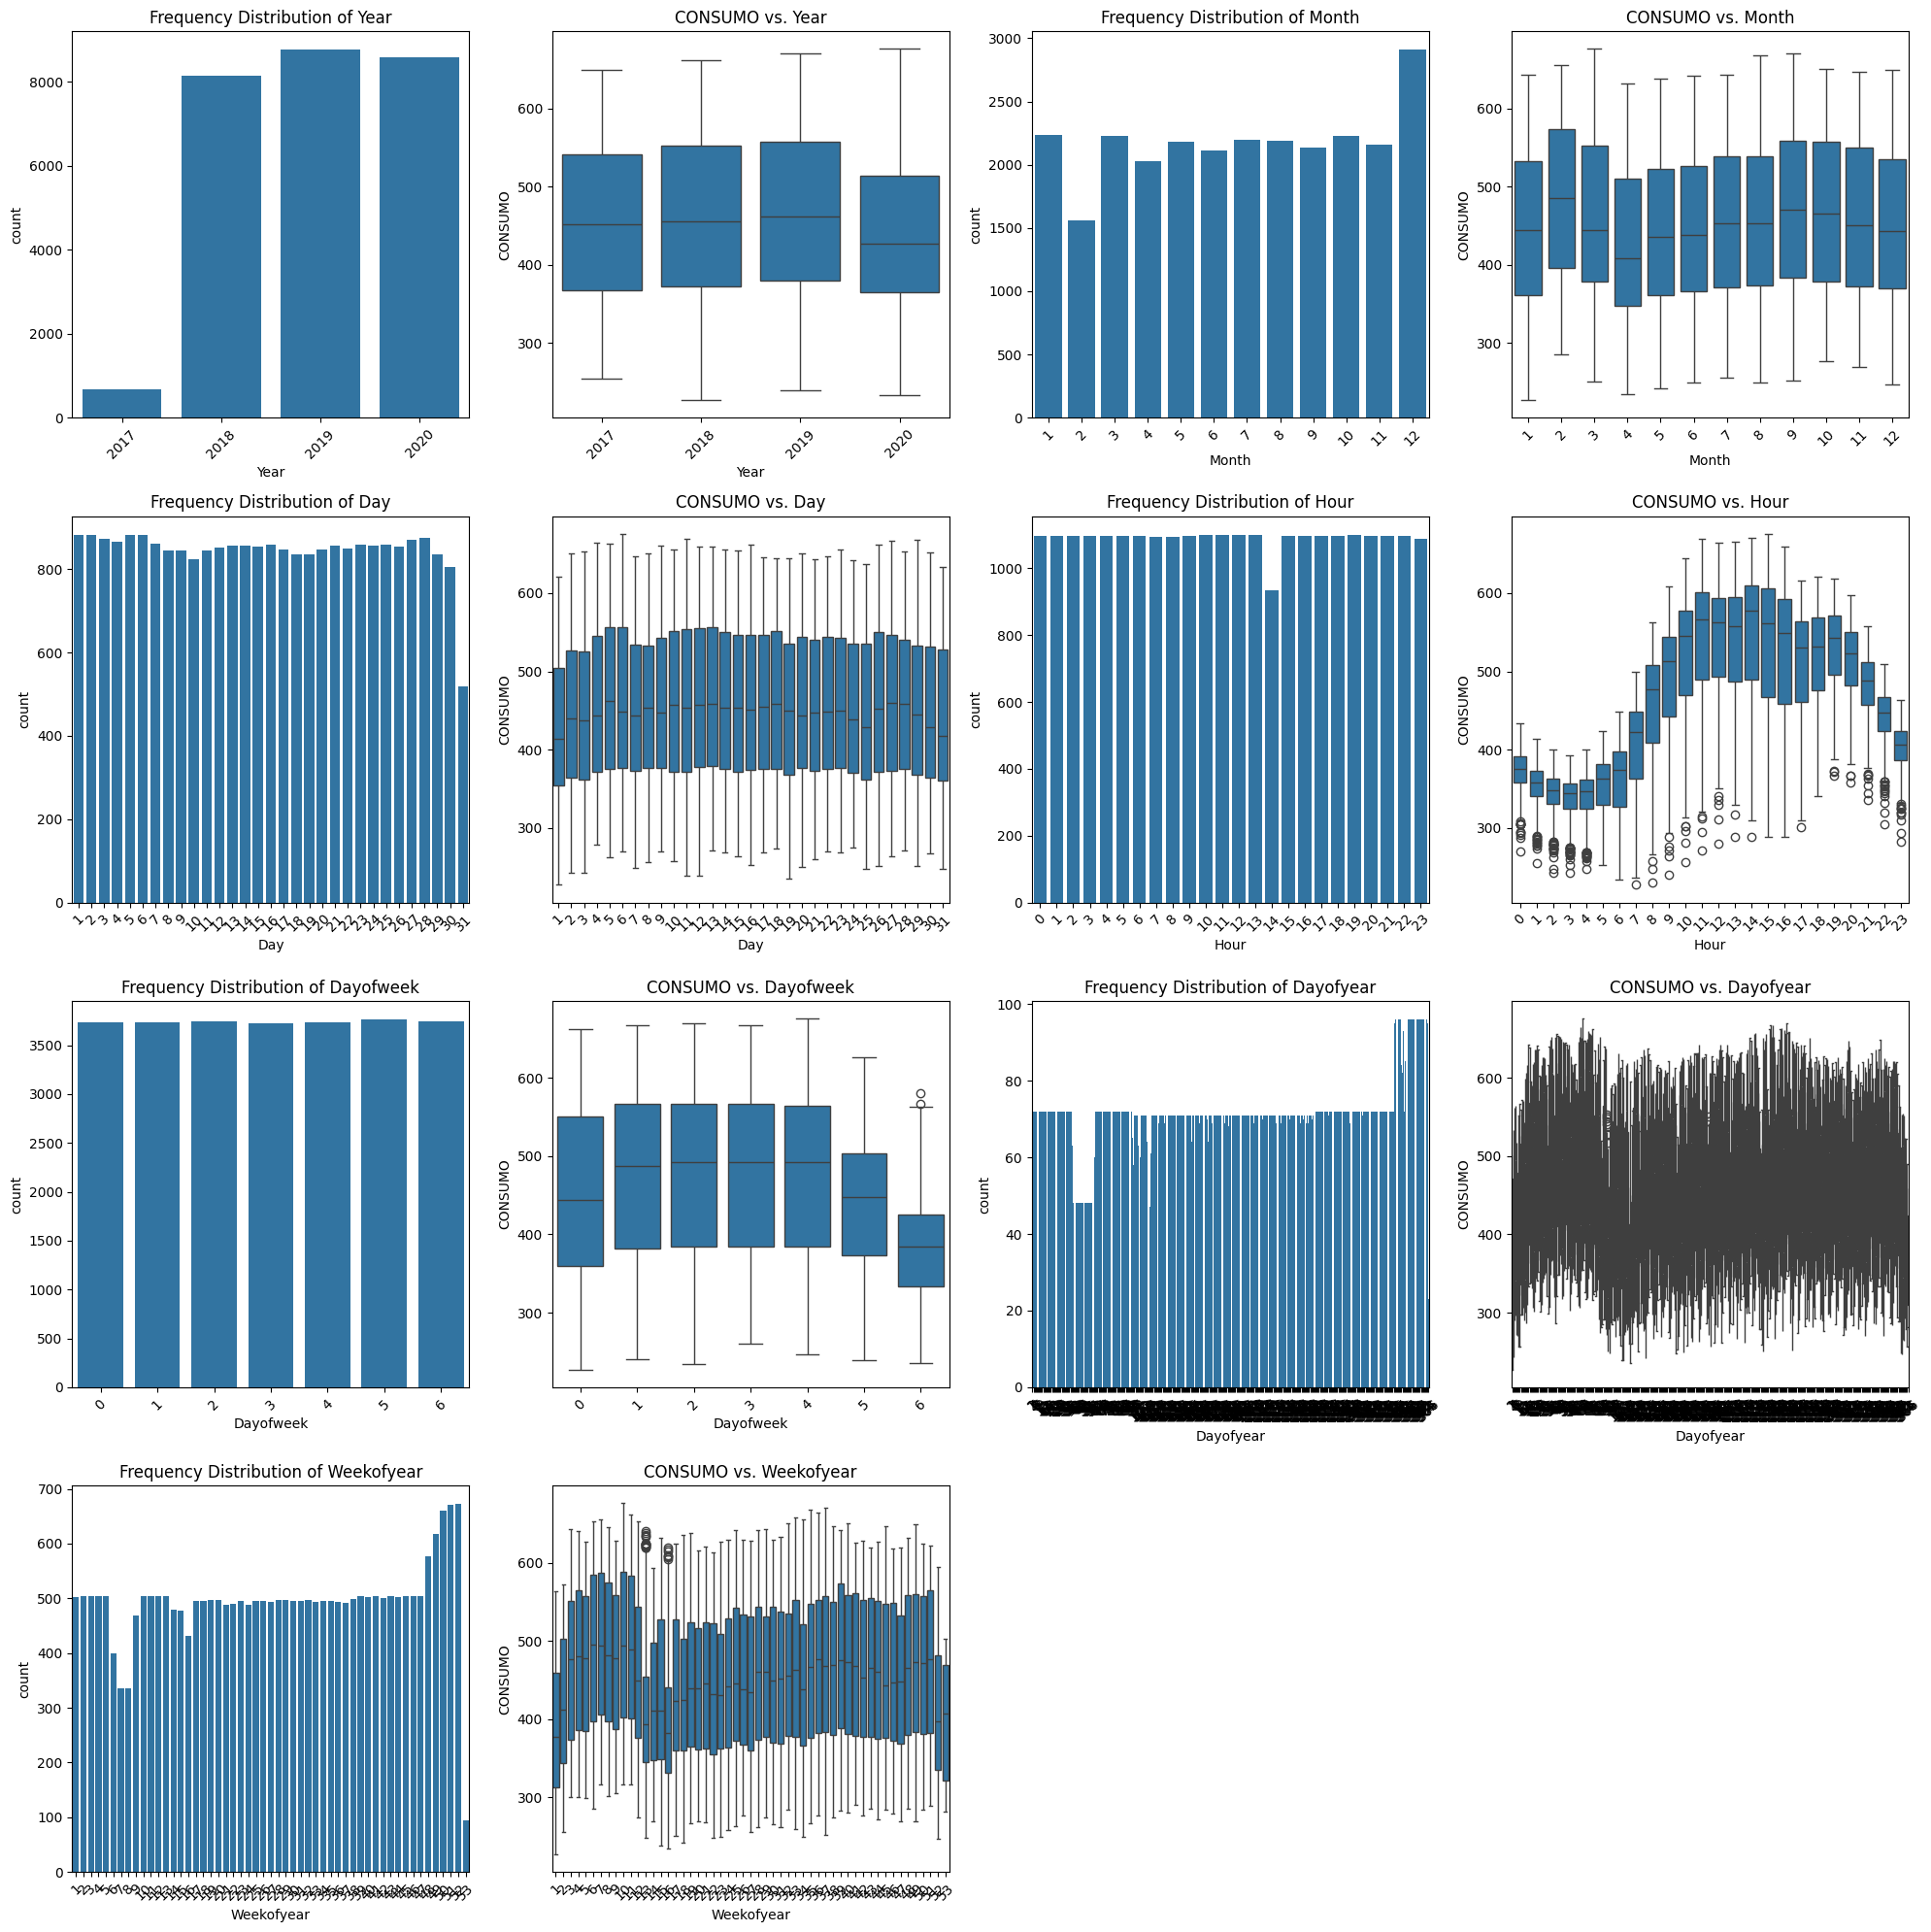

In [192]:
# Assuming 'df' is your DataFrame and 'categorical_cols' is defined
#categorical_cols = ['Year', 'Month', 'Day', 'Hour', 'Dayofweek', 'Dayofyear', 'Weekofyear']

# Determine the number of rows needed for the subplots
num_cols = 4  # 4 columns per row
num_rows = (len(categorical_cols) * 2 + num_cols - 1) // num_cols # Calculate the rows needed.

# Create subplots in a grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(categorical_cols):
    # Countplot
    sns.countplot(x=col, data=df, ax=axes[i * 2])
    axes[i * 2].set_title(f'Frequency Distribution of {col}')
    axes[i * 2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed

    # Boxplot
    sns.boxplot(x=col, y='CONSUMO', data=df, ax=axes[i * 2 + 1])
    axes[i * 2 + 1].set_title(f'CONSUMO vs. {col}')
    axes[i * 2 + 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed

# Remove any unused subplots
for j in range(len(categorical_cols) * 2, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust subplot parameters to give specified padding.
plt.show()

Los años 2020 y 2021 presentaron un fenomeno social el cual no es posible modelar en este espacio. Las restricciones a la movilidad en la pandemia y el paro nacional, impactaron directamente el consumo de eneriga en la ciudad de Cali.

Se concidera prudente, sacar del estudio estos dos años.

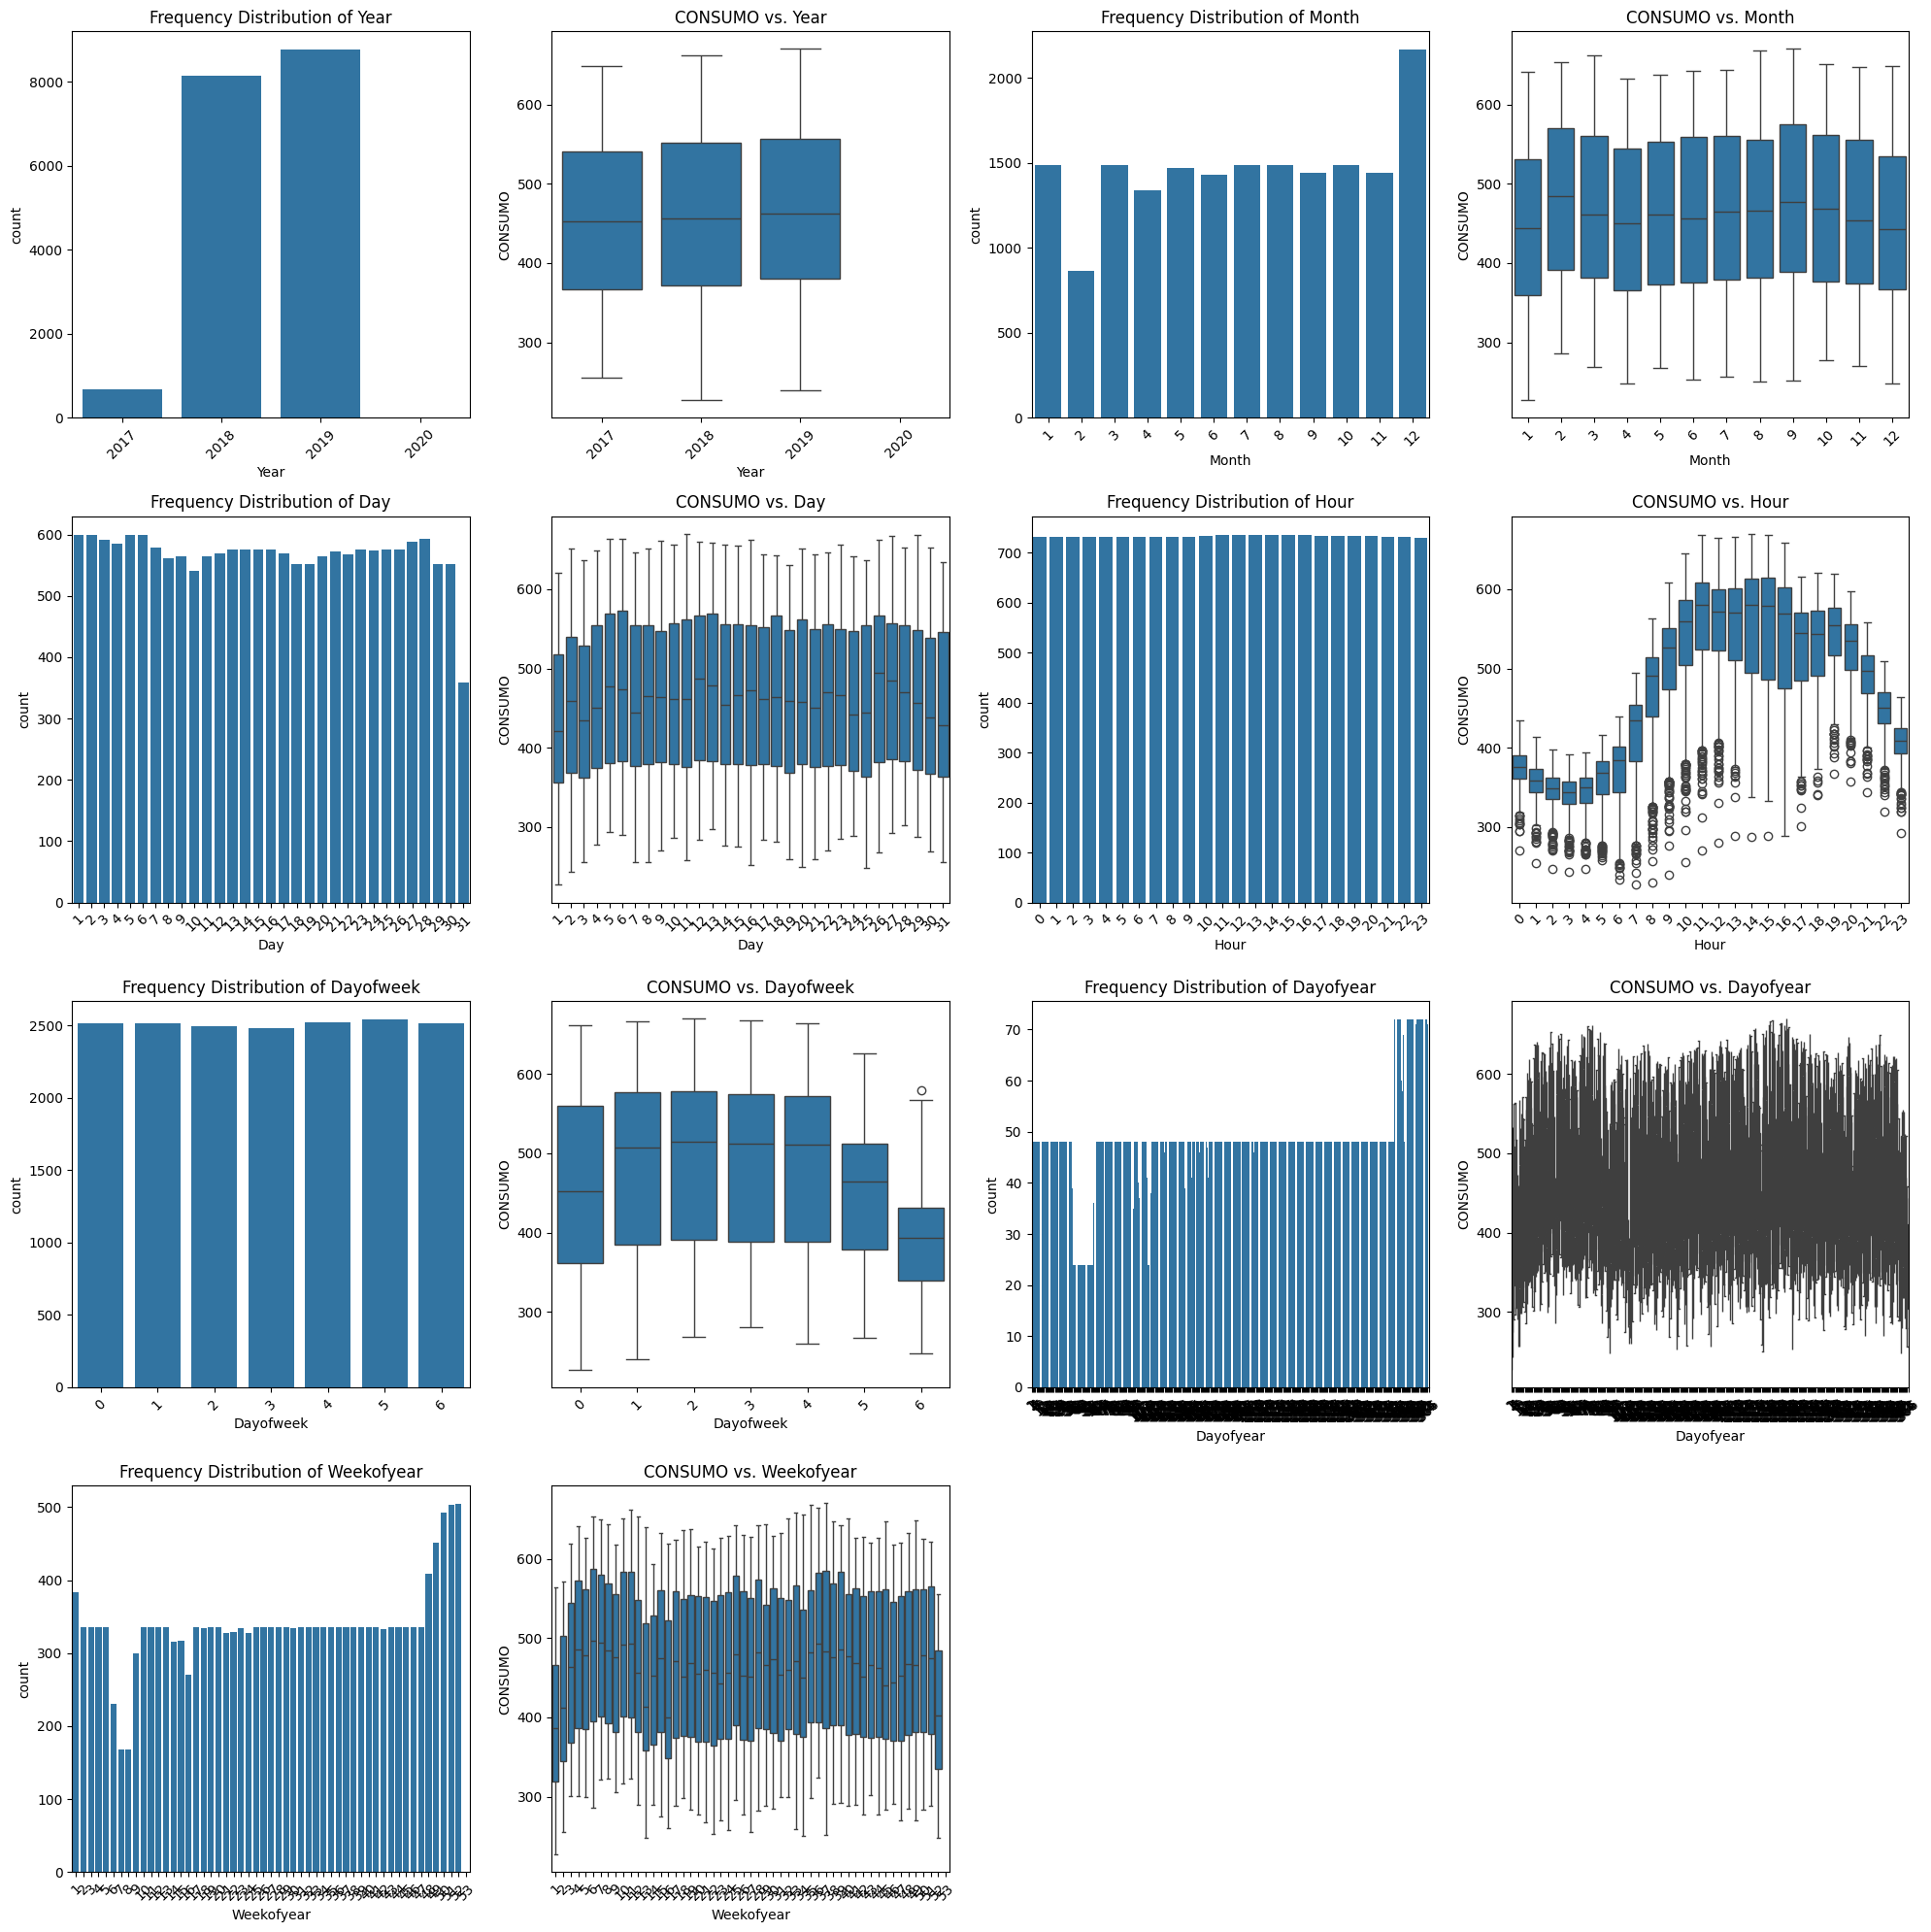

In [193]:
df = df.drop(df[(df['Year'] == 2020) | (df['Year'] == 2021)].index)
df = df.reset_index(drop=True)

num_cols = 4  # 4 columns per row
num_rows = (len(categorical_cols) * 2 + num_cols - 1) // num_cols # Calculate the rows needed.
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=df, ax=axes[i * 2])
    axes[i * 2].set_title(f'Frequency Distribution of {col}')
    axes[i * 2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed

    sns.boxplot(x=col, y='CONSUMO', data=df, ax=axes[i * 2 + 1])
    axes[i * 2 + 1].set_title(f'CONSUMO vs. {col}')
    axes[i * 2 + 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed
for j in range(len(categorical_cols) * 2, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust subplot parameters to give specified padding.
plt.show()

### 3.4.1  Analisis de outliers


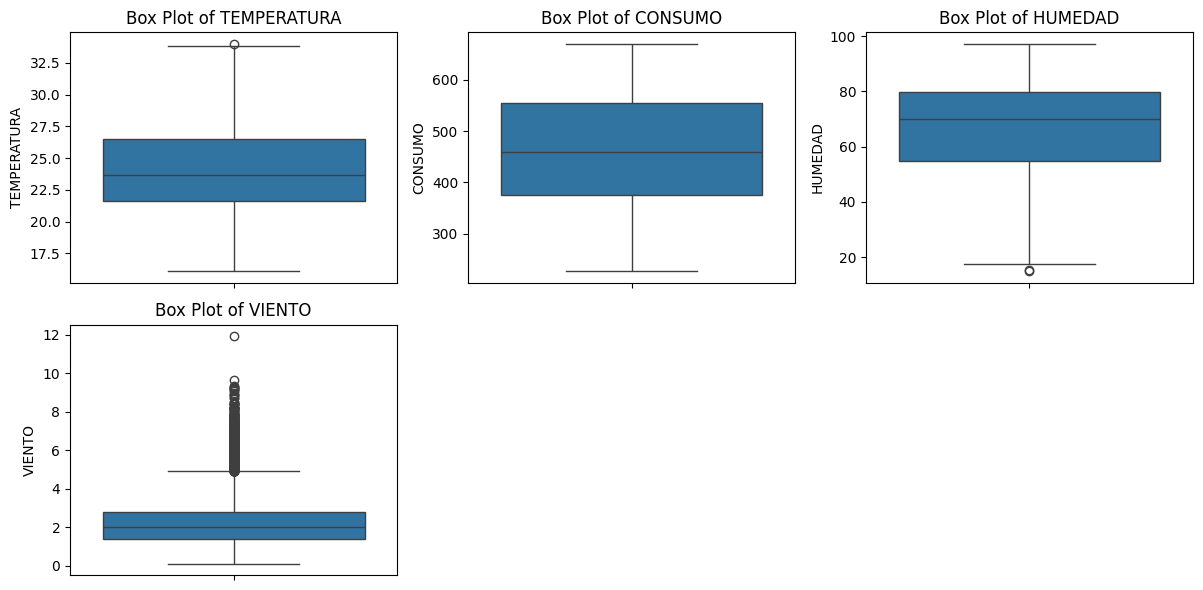


Analysis for numerical variable: TEMPERATURA
count    17584.000000
mean        24.152282
std          3.259889
min         16.100000
25%         21.600000
50%         23.700000
75%         26.500000
max         34.000000
Name: TEMPERATURA, dtype: float64
Number of outliers: 1
Lower bound: 14.250000000000004, Upper bound: 33.849999999999994
Potential causes for outliers in 'TEMPERATURA': Sensor malfunction, extreme weather events
Consequences: Skewed temperature distributions, inaccurate consumption predictions


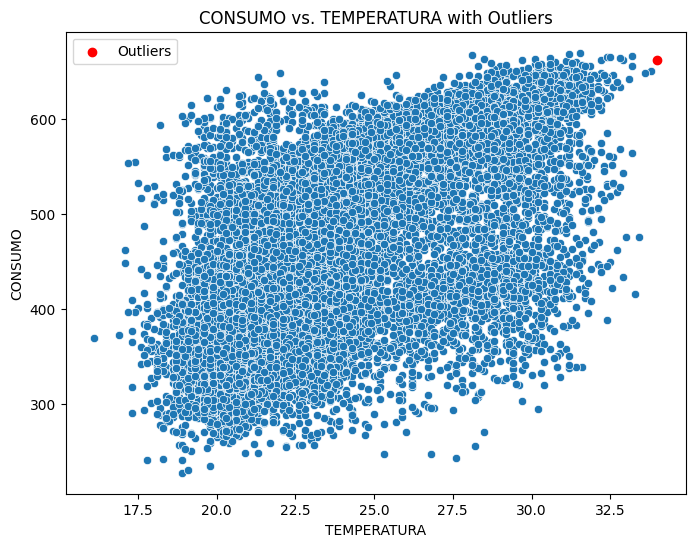


Analysis for numerical variable: CONSUMO
count    17584.000000
mean       464.446713
std         97.534335
min        227.000000
25%        376.000000
50%        459.000000
75%        554.000000
max        670.000000
Name: CONSUMO, dtype: float64
Number of outliers: 0
Lower bound: 109.0, Upper bound: 821.0


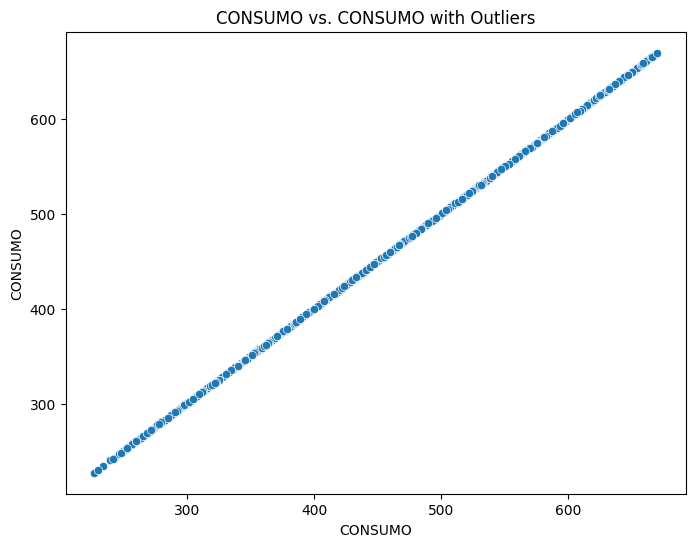


Analysis for numerical variable: HUMEDAD
count    17584.000000
mean        67.405832
std         14.418633
min         14.850000
25%         54.866667
50%         69.900000
75%         79.933333
max         97.300000
Name: HUMEDAD, dtype: float64
Number of outliers: 2
Lower bound: 17.26666666666666, Upper bound: 117.53333333333335


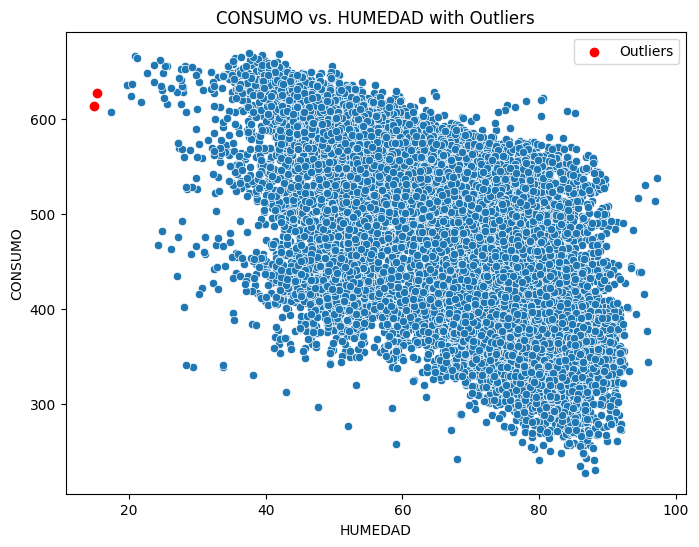


Analysis for numerical variable: VIENTO
count    17584.000000
mean         2.290743
std          1.257109
min          0.100000
25%          1.400000
50%          2.000000
75%          2.800000
max         11.933333
Name: VIENTO, dtype: float64
Number of outliers: 854
Lower bound: -0.6999999999999995, Upper bound: 4.8999999999999995


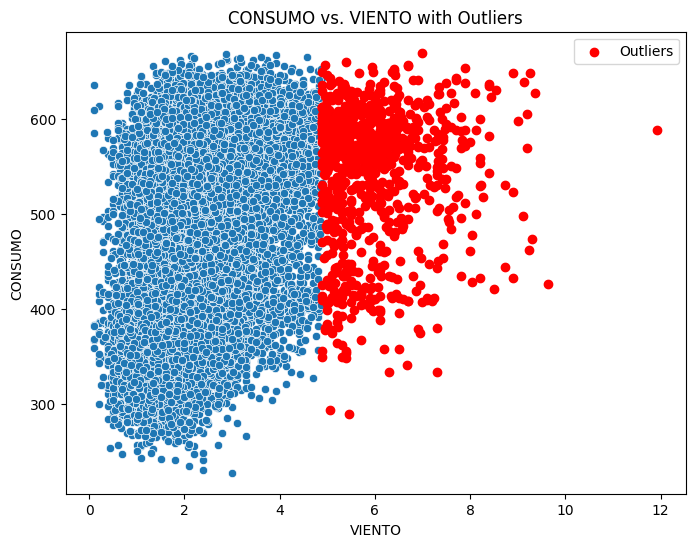

In [194]:
# Columnas numéricas
numerical_cols = ['TEMPERATURA', 'CONSUMO', 'HUMEDAD', 'VIENTO']
# Box plots to visualize outliers
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

# Descriptive statistics and IQR outlier detection
for col in numerical_cols:
    print(f"\nAnalysis for numerical variable: {col}")
    print(df[col].describe())

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Number of outliers: {len(outliers)}")
    print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
    # Document findings on potential causes and consequences of outliers (example)
    if col == 'TEMPERATURA':
        print("Potential causes for outliers in 'TEMPERATURA': Sensor malfunction, extreme weather events")
        print("Consequences: Skewed temperature distributions, inaccurate consumption predictions")

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=col, y='CONSUMO', data=df)
    plt.title(f'CONSUMO vs. {col} with Outliers')

    # Highlight outliers on the scatter plot
    if not outliers.empty:
        plt.scatter(outliers[col], outliers['CONSUMO'], color='red', label='Outliers')
        plt.legend()

    plt.show()

### 3.4.2  Conclusiones Outliers


- En el contexto energetico y de negocion, los bajos consumos se puden considedar como outliers

In [195]:
df.isnull().sum()

TEMPERATURA         0
CONSUMO             0
HUMEDAD             0
VIENTO              0
Is_holiday          0
Year                0
Month               0
Day                 0
Hour                0
Dayofweek           0
Dayofyear           0
Weekofyear          0
Is_month_end        0
Is_month_start      0
Is_quarter_end      0
Is_quarter_start    0
Is_year_end         0
Is_year_start       0
dtype: int64

# 4  Limpieza de datos


## 4.2  Imputación


In [196]:
# Create a copy of the DataFrame to avoid SettingWithCopyWarning
df_cleaned = df.copy()

# Crea series desplazadas para el valor anterior y siguiente
temperatura_anterior = df_cleaned['TEMPERATURA'].shift(1)
temperatura_siguiente = df_cleaned['TEMPERATURA'].shift(-1)

# Calcula el promedio del valor anterior y siguiente
promedio_anterior_siguiente = (temperatura_anterior + temperatura_siguiente) / 2

# Imputa los valores faltantes con el promedio
df_cleaned['TEMPERATURA'] = df_cleaned['TEMPERATURA'].fillna(promedio_anterior_siguiente)

# Manejar los valores NaN restantes al inicio o al final del DataFrame
df_cleaned['TEMPERATURA'] = df_cleaned['TEMPERATURA'].fillna(df_cleaned['TEMPERATURA'].median()) # Corregido

# Reassign the cleaned DataFrame to df
df = df_cleaned

print(df.head())
print(df.info())
print(df.isnull().sum())

   TEMPERATURA  CONSUMO  HUMEDAD  VIENTO  Is_holiday  Year Month Day Hour  \
0         27.9    409.0    72.55     2.6       False  2017    12   1    0   
1         29.0    387.0    73.40     3.1       False  2017    12   1    1   
2         29.1    378.0    75.65     2.4       False  2017    12   1    2   
3         28.2    370.0    78.35     2.3       False  2017    12   1    3   
4         26.7    364.0    80.00     1.0       False  2017    12   1    4   

  Dayofweek Dayofyear Weekofyear  Is_month_end  Is_month_start  \
0         4       335         48         False            True   
1         4       335         48         False            True   
2         4       335         48         False            True   
3         4       335         48         False            True   
4         4       335         48         False            True   

   Is_quarter_end  Is_quarter_start  Is_year_end  Is_year_start  
0           False             False        False          False  
1       

- se contempla el proceso debido a la posibilidad de la llegada de nuevos datos, a travez del cual se pueden imputan lo nuevos datos nulos. el proceso de imputacion se esat llevando a cabo teniendo en cuenta la medida anterior y posterior con referencia al dato nulo, se realiza un promedio de estas dos medidas debido a que las variaciones de la temperatura en el rango de 1 hora es minimo.
- ademas se elimina la fecha porque ya no es relevante

## 4.1  Division de datasets


In [197]:
y = df['CONSUMO']
X = df.drop(['CONSUMO'], axis=1)

print("primeras filas \n")
print(X.head())

print("se describen las columnas \n")
print(X.info())

print("dimensiones \n")
print(X.shape)
print("dimensiones \n")
print(y.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


primeras filas 

   TEMPERATURA  HUMEDAD  VIENTO  Is_holiday  Year Month Day Hour Dayofweek  \
0         27.9    72.55     2.6       False  2017    12   1    0         4   
1         29.0    73.40     3.1       False  2017    12   1    1         4   
2         29.1    75.65     2.4       False  2017    12   1    2         4   
3         28.2    78.35     2.3       False  2017    12   1    3         4   
4         26.7    80.00     1.0       False  2017    12   1    4         4   

  Dayofyear Weekofyear  Is_month_end  Is_month_start  Is_quarter_end  \
0       335         48         False            True           False   
1       335         48         False            True           False   
2       335         48         False            True           False   
3       335         48         False            True           False   
4       335         48         False            True           False   

   Is_quarter_start  Is_year_end  Is_year_start  
0             False        Fals

## 4.2  Estandarización y Escalamiento


Teniendo en cuenta que solo la variable temperatura es numerica y continua no se requiere Escalar o normalizar.

In [ ]:
# from sklearn.preprocessing import StandardScaler


# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


# 5  Feature Engineering


## 5.1  Dummificar variables


In [198]:
# Use pd.get_dummies with the 'columns' parameter to specify which columns to dummify

print(X_train.head())
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)

# Check if the number of columns in X_train and X_test are equal
print(f"Number of columns in X_train: {X_train.shape[1]} \n")
print(f"Number of columns in X_test: {X_test.shape[1]}")


       TEMPERATURA    HUMEDAD  VIENTO  Is_holiday  Year Month Day Hour  \
4918          23.4  69.150000    0.70       False  2018     7  22    0   
13126         22.1  82.033333    0.80       False  2019     6  29    5   
1583          30.7  42.150000    2.90       False  2018     2  27   13   
4903          26.1  59.800000    2.30       False  2018     7  21    9   
17017         21.1  71.500000    0.95        True  2019    12   8    8   

      Dayofweek Dayofyear Weekofyear  Is_month_end  Is_month_start  \
4918          6       203         29         False           False   
13126         5       180         26         False           False   
1583          1        58          9         False           False   
4903          5       202         29         False           False   
17017         6       342         49         False           False   

       Is_quarter_end  Is_quarter_start  Is_year_end  Is_year_start  
4918            False             False        False          Fa

## 5.2  PCA


In [199]:
# Split data into training and testing/validation sets
X_train_final, X_test_val, y_train_final, y_test_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)

# # Split testing/validation set into testing and validation sets
X_test, X_val, y_test, y_val = train_test_split(
    X_test_val, y_test_val, test_size=0.5, random_state=42
)

print(f"X_train_final shape: {X_train_final.shape}, y_train_final shape: {y_train_final.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


X_train_final shape: (9846, 507), y_train_final shape: (9846,)
X_test shape: (2110, 507), y_test shape: (2110,)
X_val shape: (2111, 507), y_val shape: (2111,)


In [ ]:

# Initialize PCA with 95% variance retained
pca = PCA(n_components=0.95)

# Fit PCA on the training data
pca.fit(X_train_final)

# Transform the training, testing, and validation data
X_train_pca = pca.transform(X_train_final)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)

# Print the explained variance ratio
print(pca.explained_variance_ratio_)

# Replace original data with PCA-transformed data
X_train_final = X_train_pca
X_test = X_test_pca
X_val = X_val_pca

## 5.3  LDA


## 5.4  Clustering


No aplica, Colocar Explicacion

# 6 Data Pipeline


In [201]:
# scoring data
from sklearn.metrics import accuracy_score

# importing pipes for making the Pipe flow
from sklearn.pipeline import Pipeline

#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


pipe = Pipeline([
  #('Estandarizacion', StandardScaler()),
  ('model', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),)
],verbose = True)

pipe.fit(X_train, y_train)

# y_pred = pipe.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_score(y_test, pipe.predict(X_test)))

[Pipeline] ............. (step 1 of 1) Processing model, total=   4.8s


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

# 7  Modelamiento

RegresionLineal

In [ ]:
# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# Calculate MAE and MedAE
mae = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Median Absolute Error (MedAE): {medae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Randomforest

In [ ]:
# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Train the model
rf_model.fit(X_train_final, y_train_final)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print the evaluation metrics
print(f"Random Forest - Mean Squared Error (MSE): {mse_rf}")
print(f"Random Forest - R-squared (R2): {r2_rf}")

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_rf)

# Calculate the Median Absolute Error (MedAE)
medae = median_absolute_error(y_test, y_pred_rf)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# Print the calculated MAE, MedAE, and RMSE values.
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Median Absolute Error (MedAE): {medae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Hiperparametros

In [ ]:
# Define la cuadrícula de hiperparámetros para buscar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
}

# Crea un objeto GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Ajusta el GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train_final, y_train_final)

# Obtén el mejor modelo
best_model = grid_search.best_estimator_

# Evalúa el mejor modelo en los datos de prueba
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

# Imprime las métricas de evaluación
print(f"Mejor modelo - Error cuadrático medio (MSE): {mse_best}")
print(f"Mejor modelo - R-cuadrado (R2): {r2_best}")

Red neuronal

In [ ]:
# 1. Definir el modelo de la red neuronal
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)  # Capa de salida para regresión
])

# 2. Compilar el modelo
model.compile(optimizer='adam', loss='mse')  # Usamos 'mse' (error cuadrático medio) para regresión

# 3. Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# 4. Realizar predicciones
y_pred = model.predict(X_test)

# 5. Calcular métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

# Opcional: Graficar la pérdida durante el entrenamiento
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Red neuronal con LSTM

In [ ]:
df.head()


In [ ]:
# 1. Preparar datos para LSTM (reshape a [muestras, pasos de tiempo, características])
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# 2. Definir el modelo LSTM
model = keras.Sequential([
    keras.layers.LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    keras.layers.Dense(1)
])

# 3. Compilar y entrenar el modelo
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=1)

# 4. Realizar predicciones
y_pred = model.predict(X_test_reshaped)

# 5. Evaluar el modelo
# (calcula métricas como MSE, MAE, etc.)